# Estudio de Indentificación de Autoría

Trabajo Fin de Grado presentado dentro del departamento de Ciencias de la Computación e Inteligencia Artificial de la Universidad de Granada.

* Escuela Técnica Superior de Ingerierías Informática y de Telecomunicación

* Tutores: Luis de Campos Ibáñez y Juan F. Miguel Huete

* Autor: Ernesto Martínez del Pino


## Indice

1. Extracción de datos

2. Preprocesamiento

3. Extracción de características

4. Selección de características

5. Selección de modelo

In [1]:
# Fijamos el directorio de trabajo
import os
os.chdir('C:/Users/ernes/Documents/Authorship')
# Añadimos las raiz para import
import sys
sys.path[0] = sys.path[0].replace('\\tests','')

import time
import pandas as pd
import numpy as np
import string
import dill as pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500

from nltk.corpus import stopwords
from string import punctuation
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix
)
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)


from Authorship.functions import (
    real_xml, 
    filter_df
)
from Authorship.feature_selection import ANOVA
from Authorship.preprocessing import (
    StopWords, 
    Stemmer, 
    Puntuation, 
    Translate
)
from Authorship.feature_extration.text import Sequences
from Authorship.neural_network import (
    MLPClassifier,
    LSTMClassifier,
    GRUClassifier, 
    SC1DClassifier
)

Variables globales

In [2]:
random_state = 1
nwords = 50
frecuency = 200
subset = None
nfiles = None

## 1. Extracción de datos

Realizamos la lectura de los XMLs y la transformamos a dataframe.

In [3]:
df = real_xml('./iniciativas08/', nfiles = nfiles)
print('Número de documentos: ', df.shape[0])
print('Número de columnas: ', df.shape[1])
print('Número de etiquetas: ', len(df['name'].unique()))

Número de documentos:  58275
Número de columnas:  2
Número de etiquetas:  590


El dataframe esta organizado en 2 columnas:
1. La segunda contiene el **nombre** ("name") o el autor de la iniciativa parlamentaria.
2. La primera contiene el **texto** ("text") de la iniciativa parlamentaria.

In [4]:
df.columns.tolist()

['name', 'text']

Veamos las primeras 5 filas del conjunto de datos de forma truncada:

In [5]:
df.head(5).apply(lambda row: {
    'name': row['name'], 
    'text': row['text'][:50]
}, axis = 1, result_type = 'expand')

,name,text
0,COVES BOTELLA,"Buenos días, señorías.. Se abre la sesión con ..."
1,LETRADO MAYOR,"Bueno, declaro constituida la Comisión de Gobi..."
2,COVES BOTELLA,Pasamos al segundo punto del orden del día. Pr...
3,GARCÍA GARRIDO,"Muchas gracias, Presidenta. Señorías.. Una vez..."
4,COVES BOTELLA,"Muchas gracias, señor García Garrido.. ¿Tienen..."


### 2.1 Primer filtro
A continuación, vamos a realizar un pequeño estudio sobre el número de palabras por intervención que hay el conjunto de datos.

In [6]:
df['nwords'] = df['text'].apply(lambda s: len(s.split(' ')))
df['nwords'].describe()

count    58275.000000
mean       323.676585
std        649.222869
min          1.000000
25%         13.000000
50%         44.000000
75%        310.000000
max      12474.000000
Name: nwords, dtype: float64

Representamos gráficamente estos números:

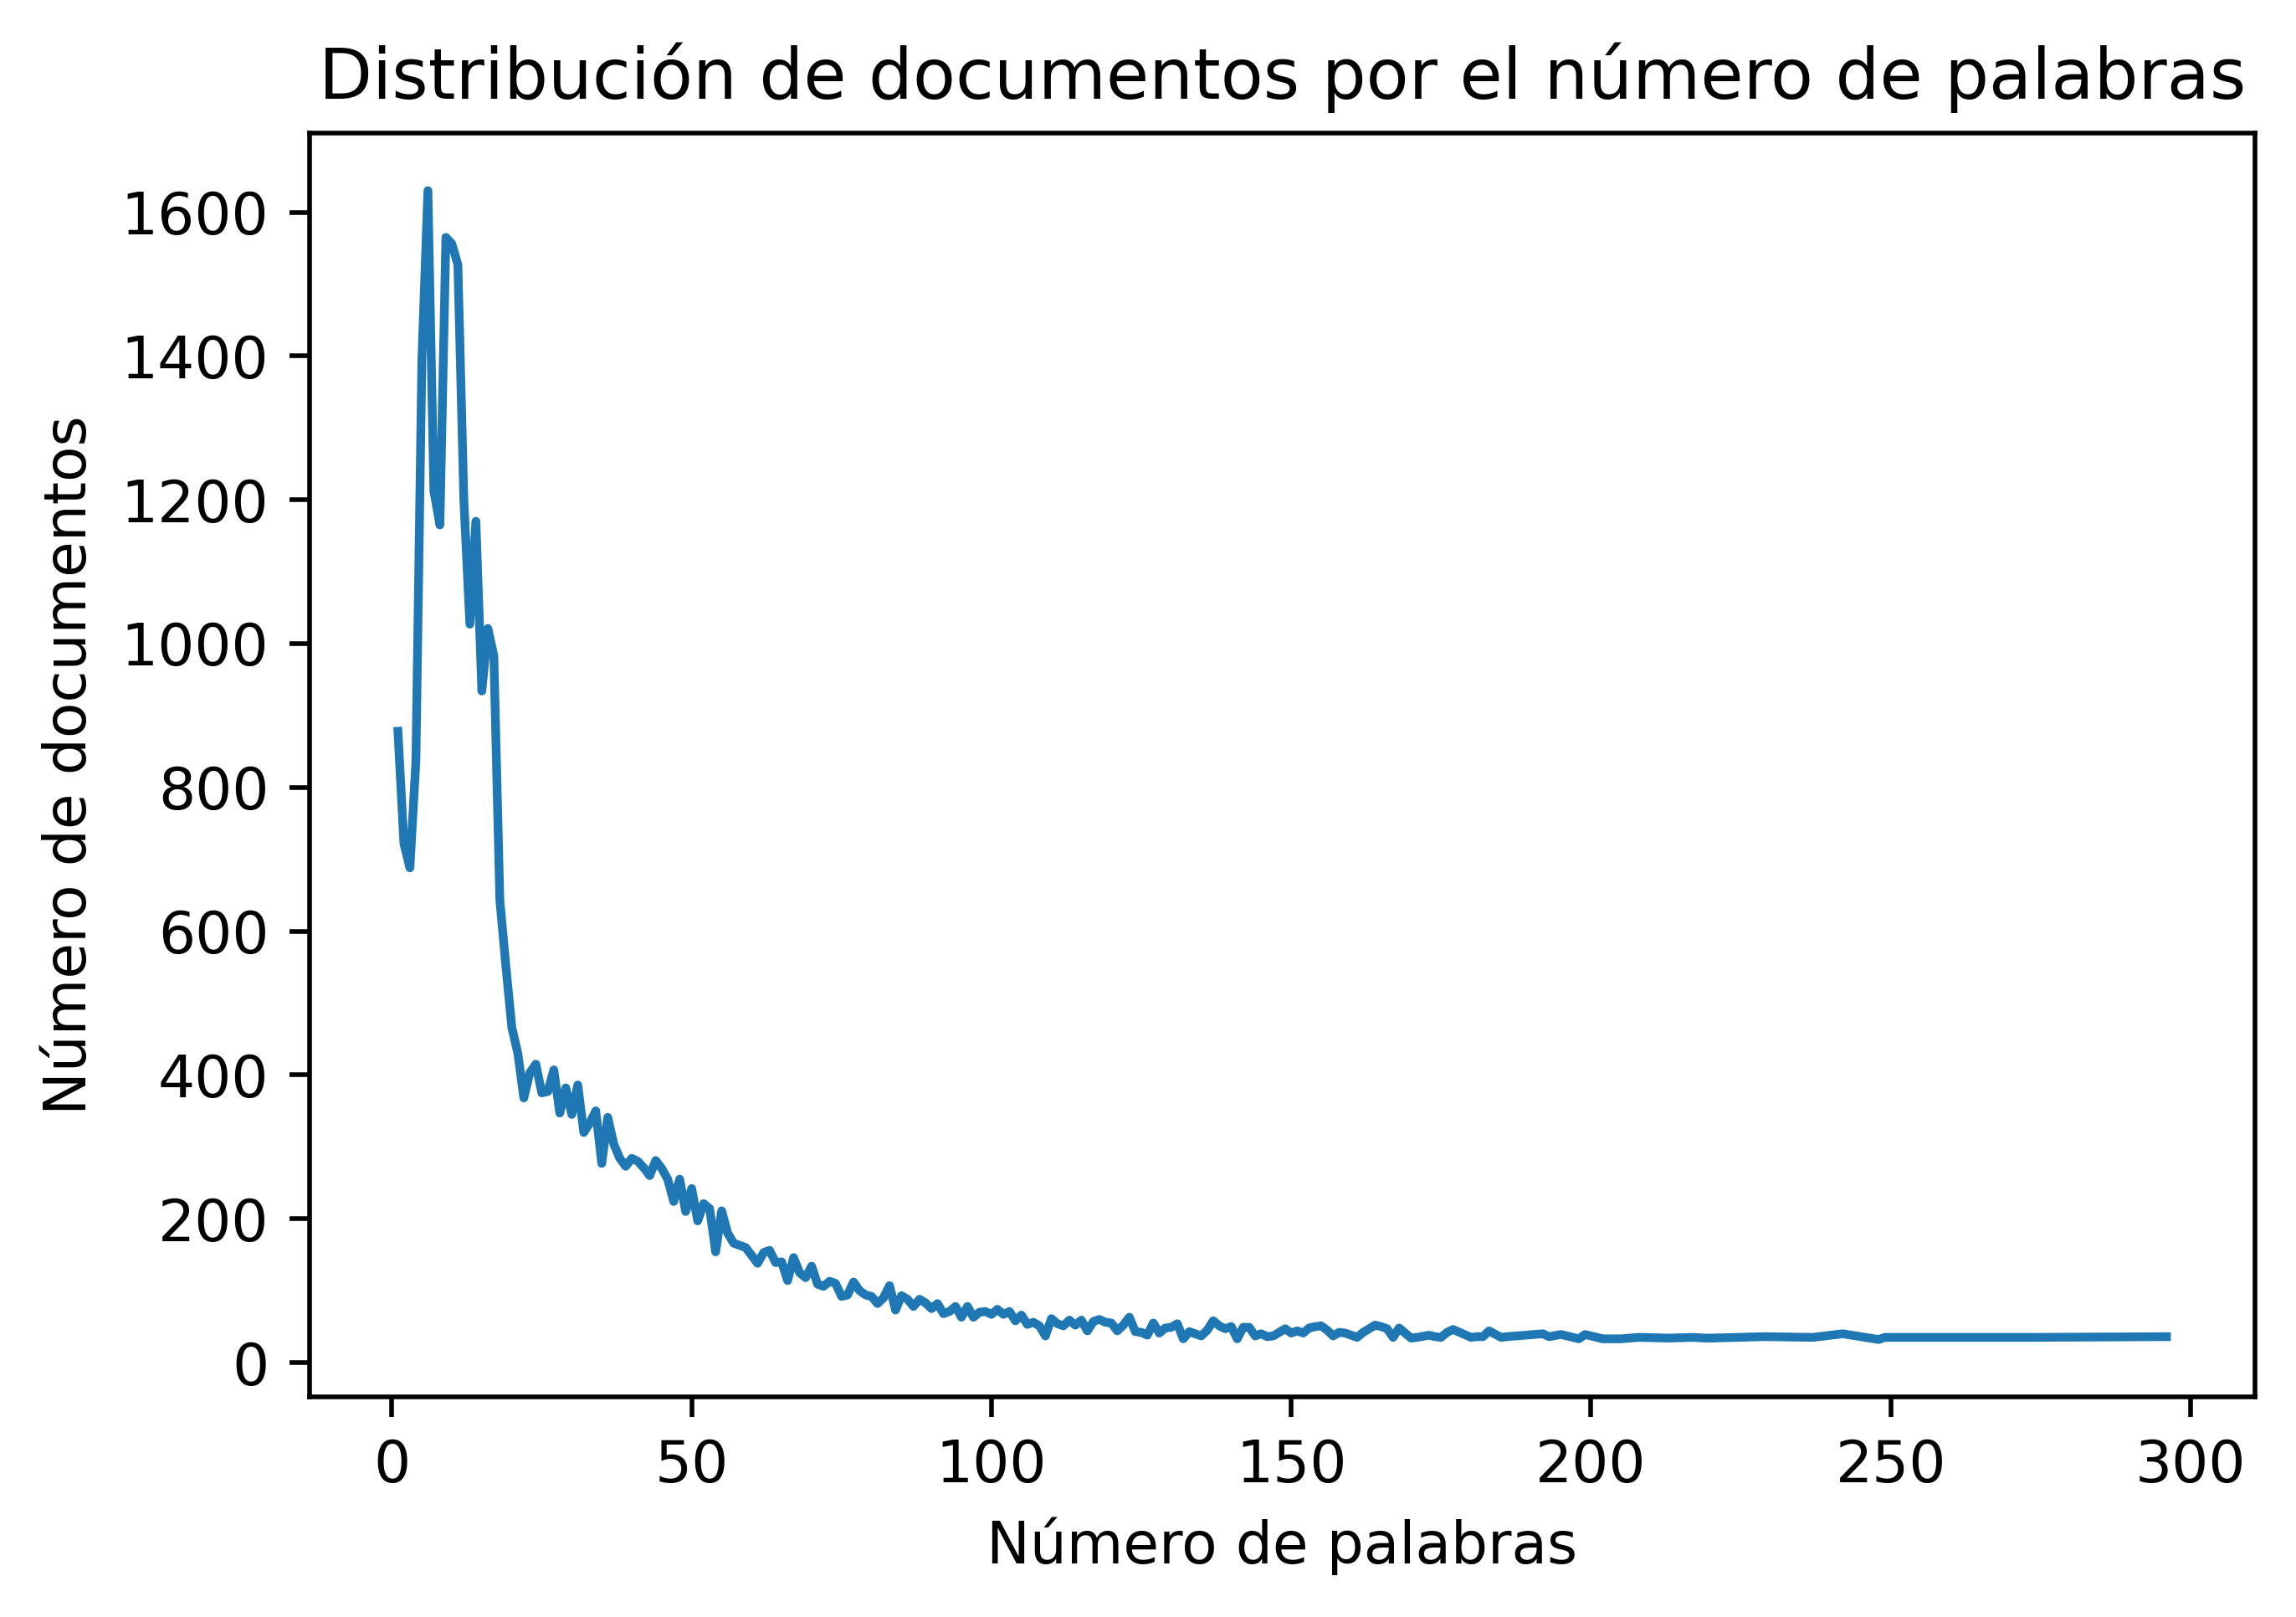

In [7]:
word_count = df['nwords'].value_counts().head(200).sort_index()
fig, ax = plt.subplots()
plt.xlabel('Número de palabras')
plt.ylabel('Número de documentos')
plt.title('Distribución de documentos por el número de palabras')
ax.plot(word_count.index,word_count)

Tras observar la necesidad de eliminar lo documentos cortos, procedemos a aplicar el filtro:

In [8]:
df2 = df.copy()
df2 = df2[df2['nwords'] > nwords]
print('Número de documentos: ', df2.shape[0])
print('Número de columnas: ', df2.shape[1])
print('Número de etiquetas: ', len(df2['name'].unique()))

Número de documentos:  27555
Número de columnas:  3
Número de etiquetas:  475


Actualizamos la gráfica anterior:

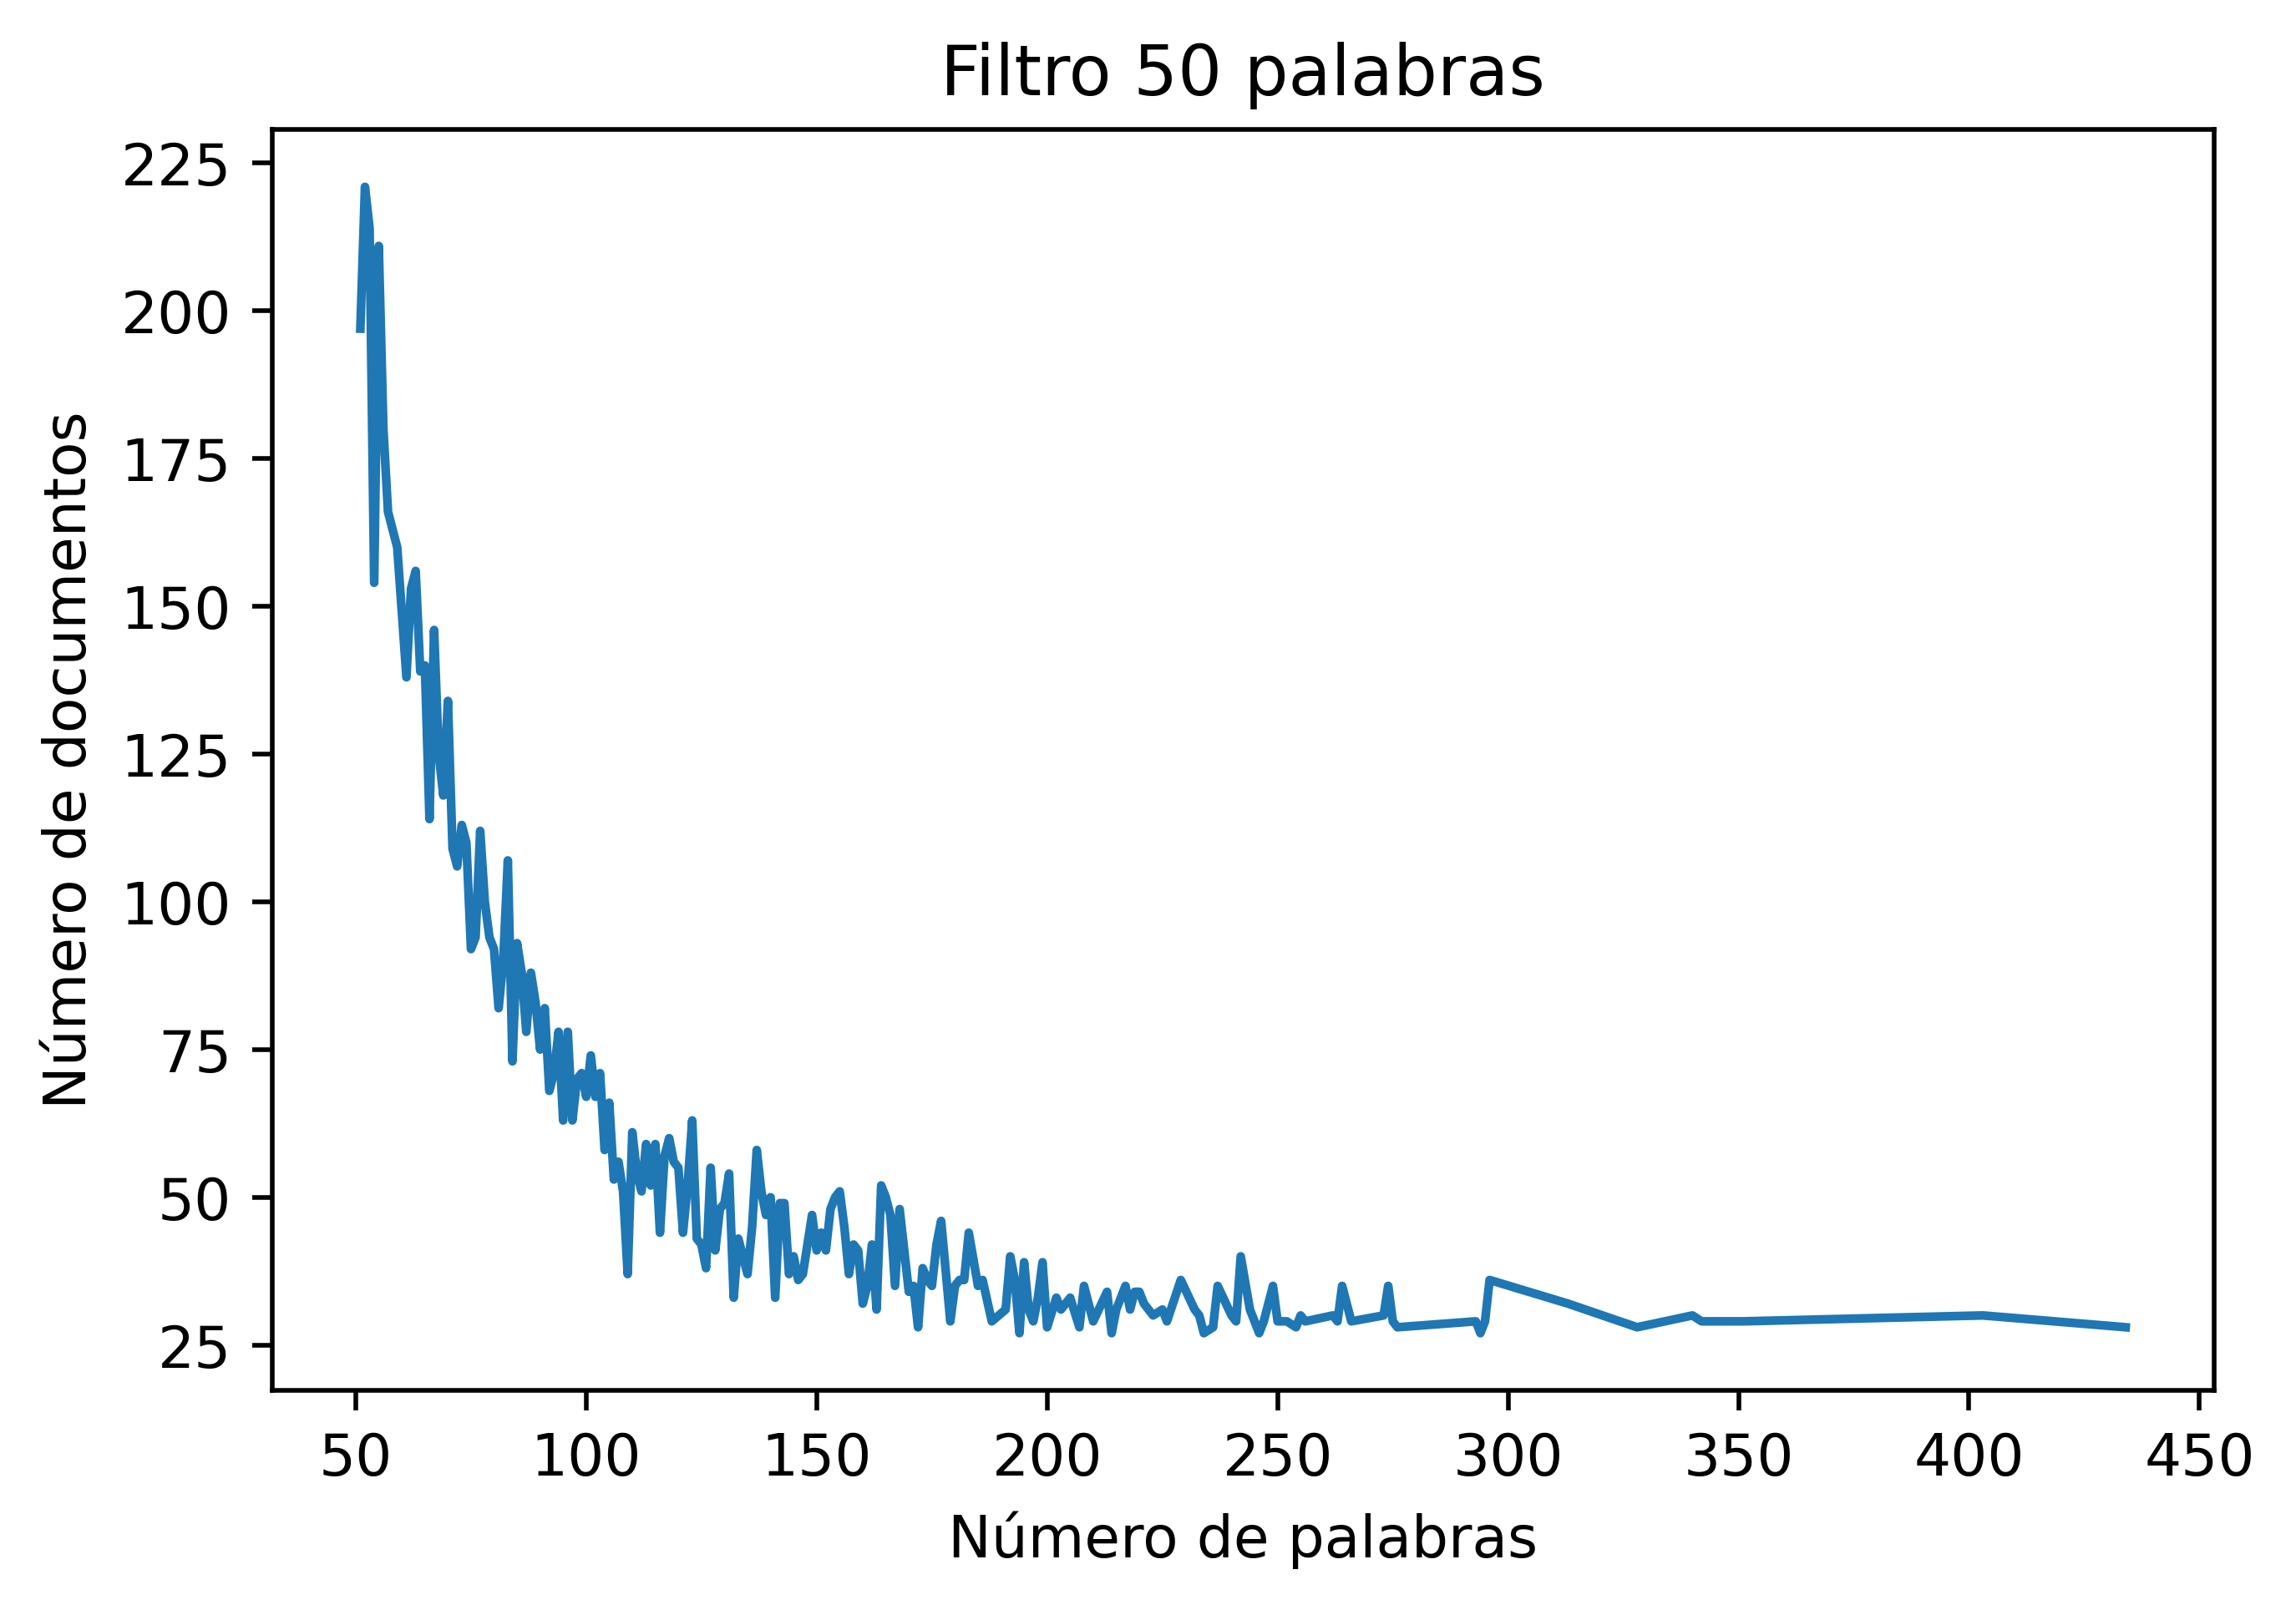

In [9]:
word_count = df2['nwords'].value_counts().head(200).sort_index()
fig, ax = plt.subplots()
plt.xlabel('Número de palabras')
plt.ylabel('Número de documentos')
plt.title('Filtro 50 palabras')
ax.plot(word_count.index,word_count)

Tabla estadística con el primer filtro:

In [10]:
df2['nwords'] = df2['text'].apply(lambda s: len(s.split(' ')))
df2['nwords'].describe()

count    27555.000000
mean       665.096462
std        818.593464
min         51.000000
25%        120.000000
50%        346.000000
75%        931.000000
max      12474.000000
Name: nwords, dtype: float64

### 1.2 Segundo Filtro
Realicemos un pequeño analisis del número de documentos asociados a cada etiqueta sobre el conjunto de datos resultante del primer filtro aplicado.

In [11]:
df2['name'].value_counts().describe()

count     475.000000
mean       58.010526
std       131.854966
min         1.000000
25%         1.000000
50%         2.000000
75%        39.000000
max      1583.000000
Name: name, dtype: float64

Mostremos en un gráfico de barras las primero X etiquetas con más documentos asociados:

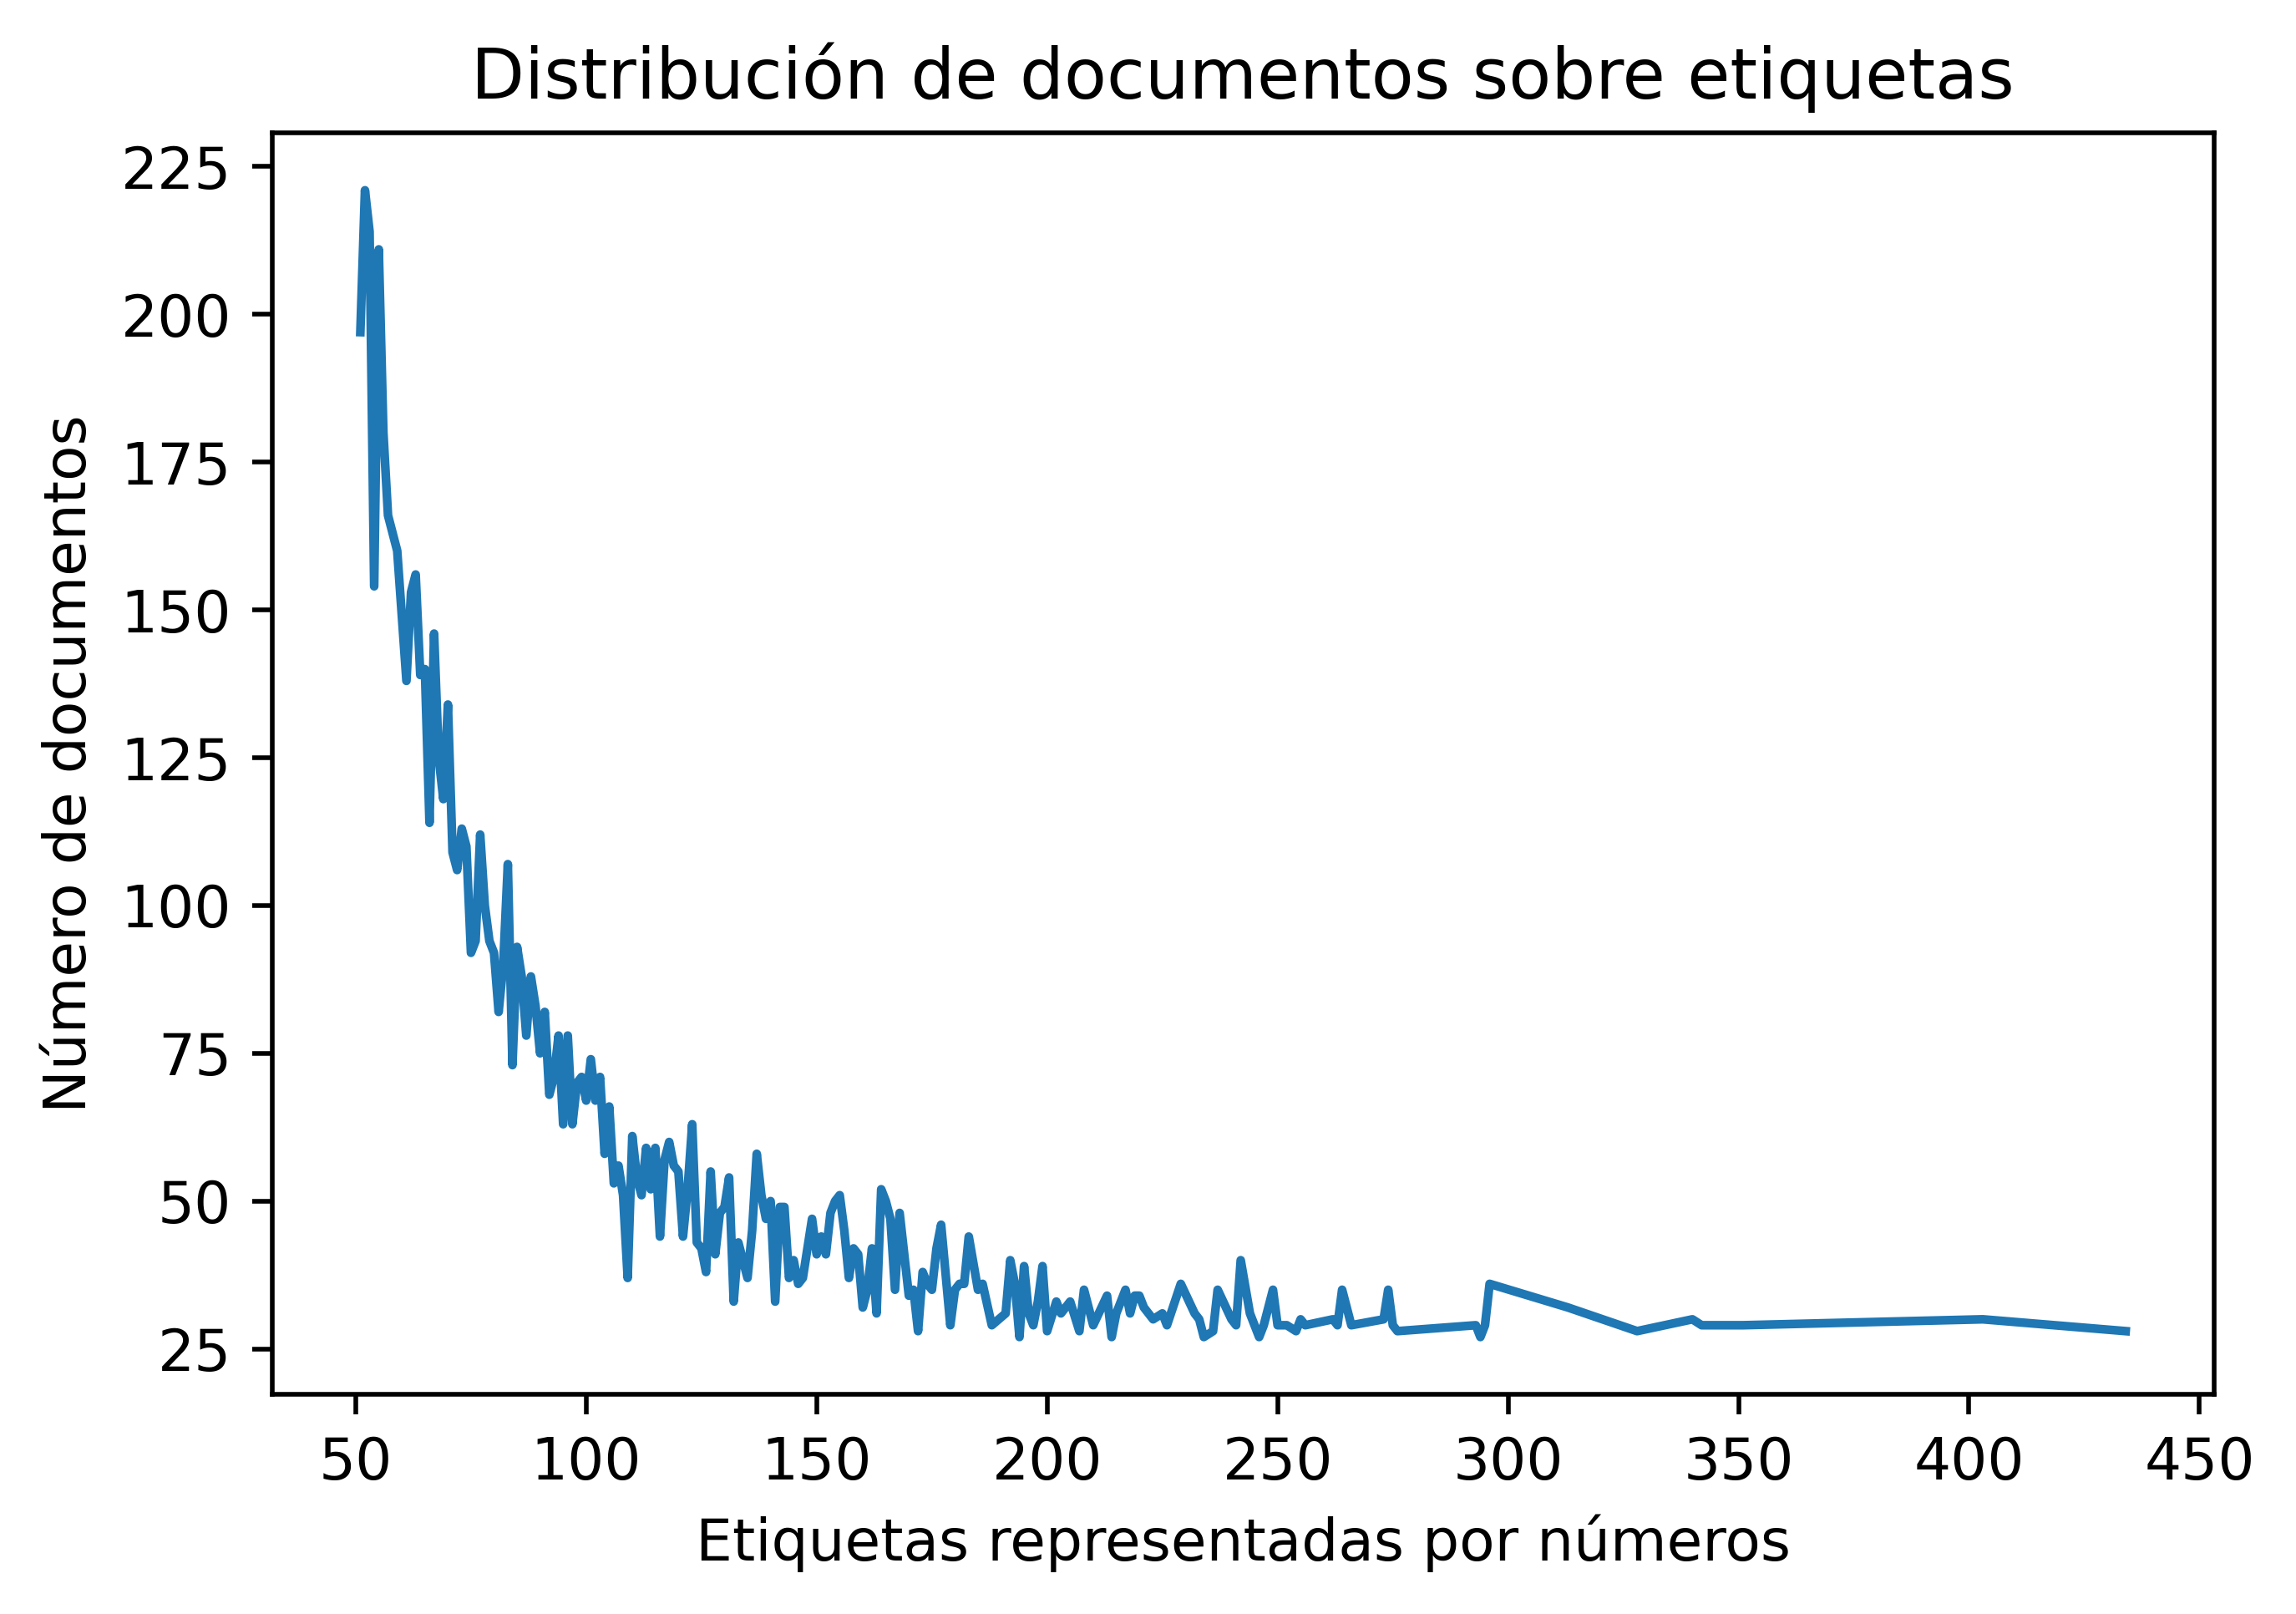

In [12]:
doc_count = df2['name'].value_counts()
doc_count.index = pd.Index(range(doc_count.shape[0]))
fig, ax = plt.subplots()
plt.xlabel('Etiquetas representadas por números')
plt.ylabel('Número de documentos')
plt.title('Distribución de documentos sobre etiquetas')
ax.plot(word_count.index,word_count)

In [13]:
print(doc_count[doc_count < 200].shape[0], 'etiquetas presentan menos de 200 documentos asociados.')
print('Total: ', doc_count.shape[0])
print('Resultado: ', doc_count.shape[0] - doc_count[doc_count < 200].shape[0])

420 etiquetas presentan menos de 200 documentos asociados.
Total:  475
Resultado:  55


Imprimimos la tabla de etiquetas número documentos

In [24]:
doc_count = df2['name'].value_counts()
doc_count[doc_count >= 200]

COVES BOTELLA          1583
GARCÍA RODRÍGUEZ        779
SÁNCHEZ GORDILLO        625
VAQUERO DEL POZO        601
VALDERAS SOSA           534
CASTILLO JIMÉNEZ        476
MONTERO CUADRADO        435
NAVARRO GARZÓN          420
CASTRO ROMÁN            420
ARENAL CATENA           411
MARTÍNEZ AGUAYO         397
RODRÍGUEZ DOMÍNGUEZ     391
MARTÍNEZ VIDAL          385
ÁVILA CANO              363
CEBRIÁN PASTOR          361
ÁLVAREZ DE LA CHICA     357
AGUILERA GARCÍA         356
FUENTES LOPERA          355
GRIÑÁN MARTÍNEZ         353
NIETO BALLESTEROS       328
ESPADAS CEJAS           327
SANZ CABELLO            323
NÚÑEZ ROLDÁN            315
SOLER MÁRQUEZ           312
GONZÁLEZ VIGO           307
RAYNAUD SOTO            304
MORENO RUIZ             303
DÍAZ TRILLO             303
RECIO MENÉNDEZ          299
FERNÁNDEZ GARCÍA        291
RAMOS AZNAR             290
MARISCAL CIFUENTES      284
JIMÉNEZ VÍLCHEZ         281
MESA CIRIZA             278
CÓZAR ANDRADES          277
ALONSO ALONSO       

El conjunto de datos contiene documentos demasiado cortos para realizar un entrenamiento. También contiene etiquetas demasiado poco frecuentes. Vamos a aplicar un filtro:

In [25]:
df = filter_df(df, nwords = nwords, frecuency = frecuency)
print('Número de documentos: ', df.shape[0])
print('Número de columnas: ', df.shape[1])
print('Número de etiquetas: ', len(df['name'].unique()))

Número de documentos:  19113
Número de columnas:  4
Número de etiquetas:  55


In [26]:
df[['nwords']].describe()

,nwords
count,19113.000000
mean,643.178831
std,818.744786
min,51.000000
25%,111.000000
50%,326.000000
75%,867.000000
max,12474.000000


In [17]:

stop_words = stopwords.words("spanish") + list(punctuation)
wordcloud = WordCloud(normalize_plurals = False,max_font_size=200, width = 800, height = 400, max_words=200, background_color="white", stopwords = stop_words).generate(' '.join(list(df['text'].head(5000).values)).lower())
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file('prueba.png')

NameError: name 'WordCloud' is not defined

In [ ]:
A = df['nwords'].value_counts().head(100)
x = A.index.values
y = A.values
fig, ax = plt.subplots()
plt.xlabel('Número de palabras')
plt.ylabel('Número de documentos')
plt.title('Distribución de documentos por el número de palabras: 50')
ax.bar(x,y)

In [ ]:
x = [0.0,0.1,0.2,0.3]
y = [0.852,0.854,0.8535,0.8552]
fig, ax = plt.subplots()
plt.xlabel('Número de capas')
plt.ylabel('Puntuación media')
plt.title('Ajuste del parámetro Capas')
ax.plot(x,y)

In [ ]:
A = df['name'].value_counts().head(25)
x = A.index.values
y = list(A.values)
fig, ax = plt.subplots()
plt.xlabel('Número de documentos')
plt.ylabel('Nombres o etiquetas')

plt.title('Distribución de documentos por etiqueta')
ax.bar(x,y)
plt.xticks(x,x, rotation = 'vertical')
df['name'].value_counts()[df['name'].value_counts() < 200]

In [ ]:
print('Numero de documentos: ', df.shape[0])
print('Etiquetas: ', len(le.classes_))

X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['name'],
    test_size = 0.2,
    random_state = random_state
)
print("Train: ", X_train.shape)
print("Test: ", X_test.shape)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


In [ ]:
from nltk.corpus import stopwords
from string import punctuation
stop_words = stopwords.words("spanish") + list(punctuation)
Vectorizer = CountVectorizer(
    stop_words = stop_words,
    analyzer = 'word',
    encoding = 'utf8',
    dtype = np.float32,
    ngram_range = (1,2),
    max_features = 100000,
    min_df = 1.0 / 1000.0,
    max_df = 999.0 / 1000.0,
    strip_accents = 'unicode',
    decode_error = 'replace',
    lowercase = True
)

In [ ]:
Vectorizer.fit(X_train,y_train)
X = Vectorizer.transform(X_train)

In [ ]:
from sklearn.feature_selection import f_classif
f_classif(X, y_train)[0][:10]

In [ ]:
suma = X.sum(axis = 0)
words_freq = [(word, suma[0,idx]) for word, idx in Vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
words_freq[:10]

In [ ]:
ws = []
fs = []
for w,f in words_freq[:25]:
    ws.append(w)
    fs.append(f)
fs

In [ ]:
fig, ax = plt.subplots()
hist = ax.bar(ws,fs)
plt.xticks(ws,ws, rotation = 'vertical')
plt.xlabel('Tokens')
plt.ylabel('Frecuencia absoluta')
plt.title('Distribución de frecuencias de la plabras')
ax.plot()

In [ ]:
from sklearn.feature_selection import f_classif
f_classif(X), y_train)

In [ ]:
x = [4,3,2,4,1,4.5,3,2]
y = [2,3,4.5,4.75,4,2,4,3]
fig, ax = plt.subplots()
ax.scatter(x,y, c = 'b')
x = [6,7,8,7,6,7,8,6]
y = [8,5.5,6,7,8,9,7,6]
ax.scatter(x,y, c = 'r')
ax.plot([9,1],[1,9], 'y')
ax.plot([10,1.3],[1,8], 'y')
ax.plot([9.5,0.6],[1,7.7], 'y')

plt.show()

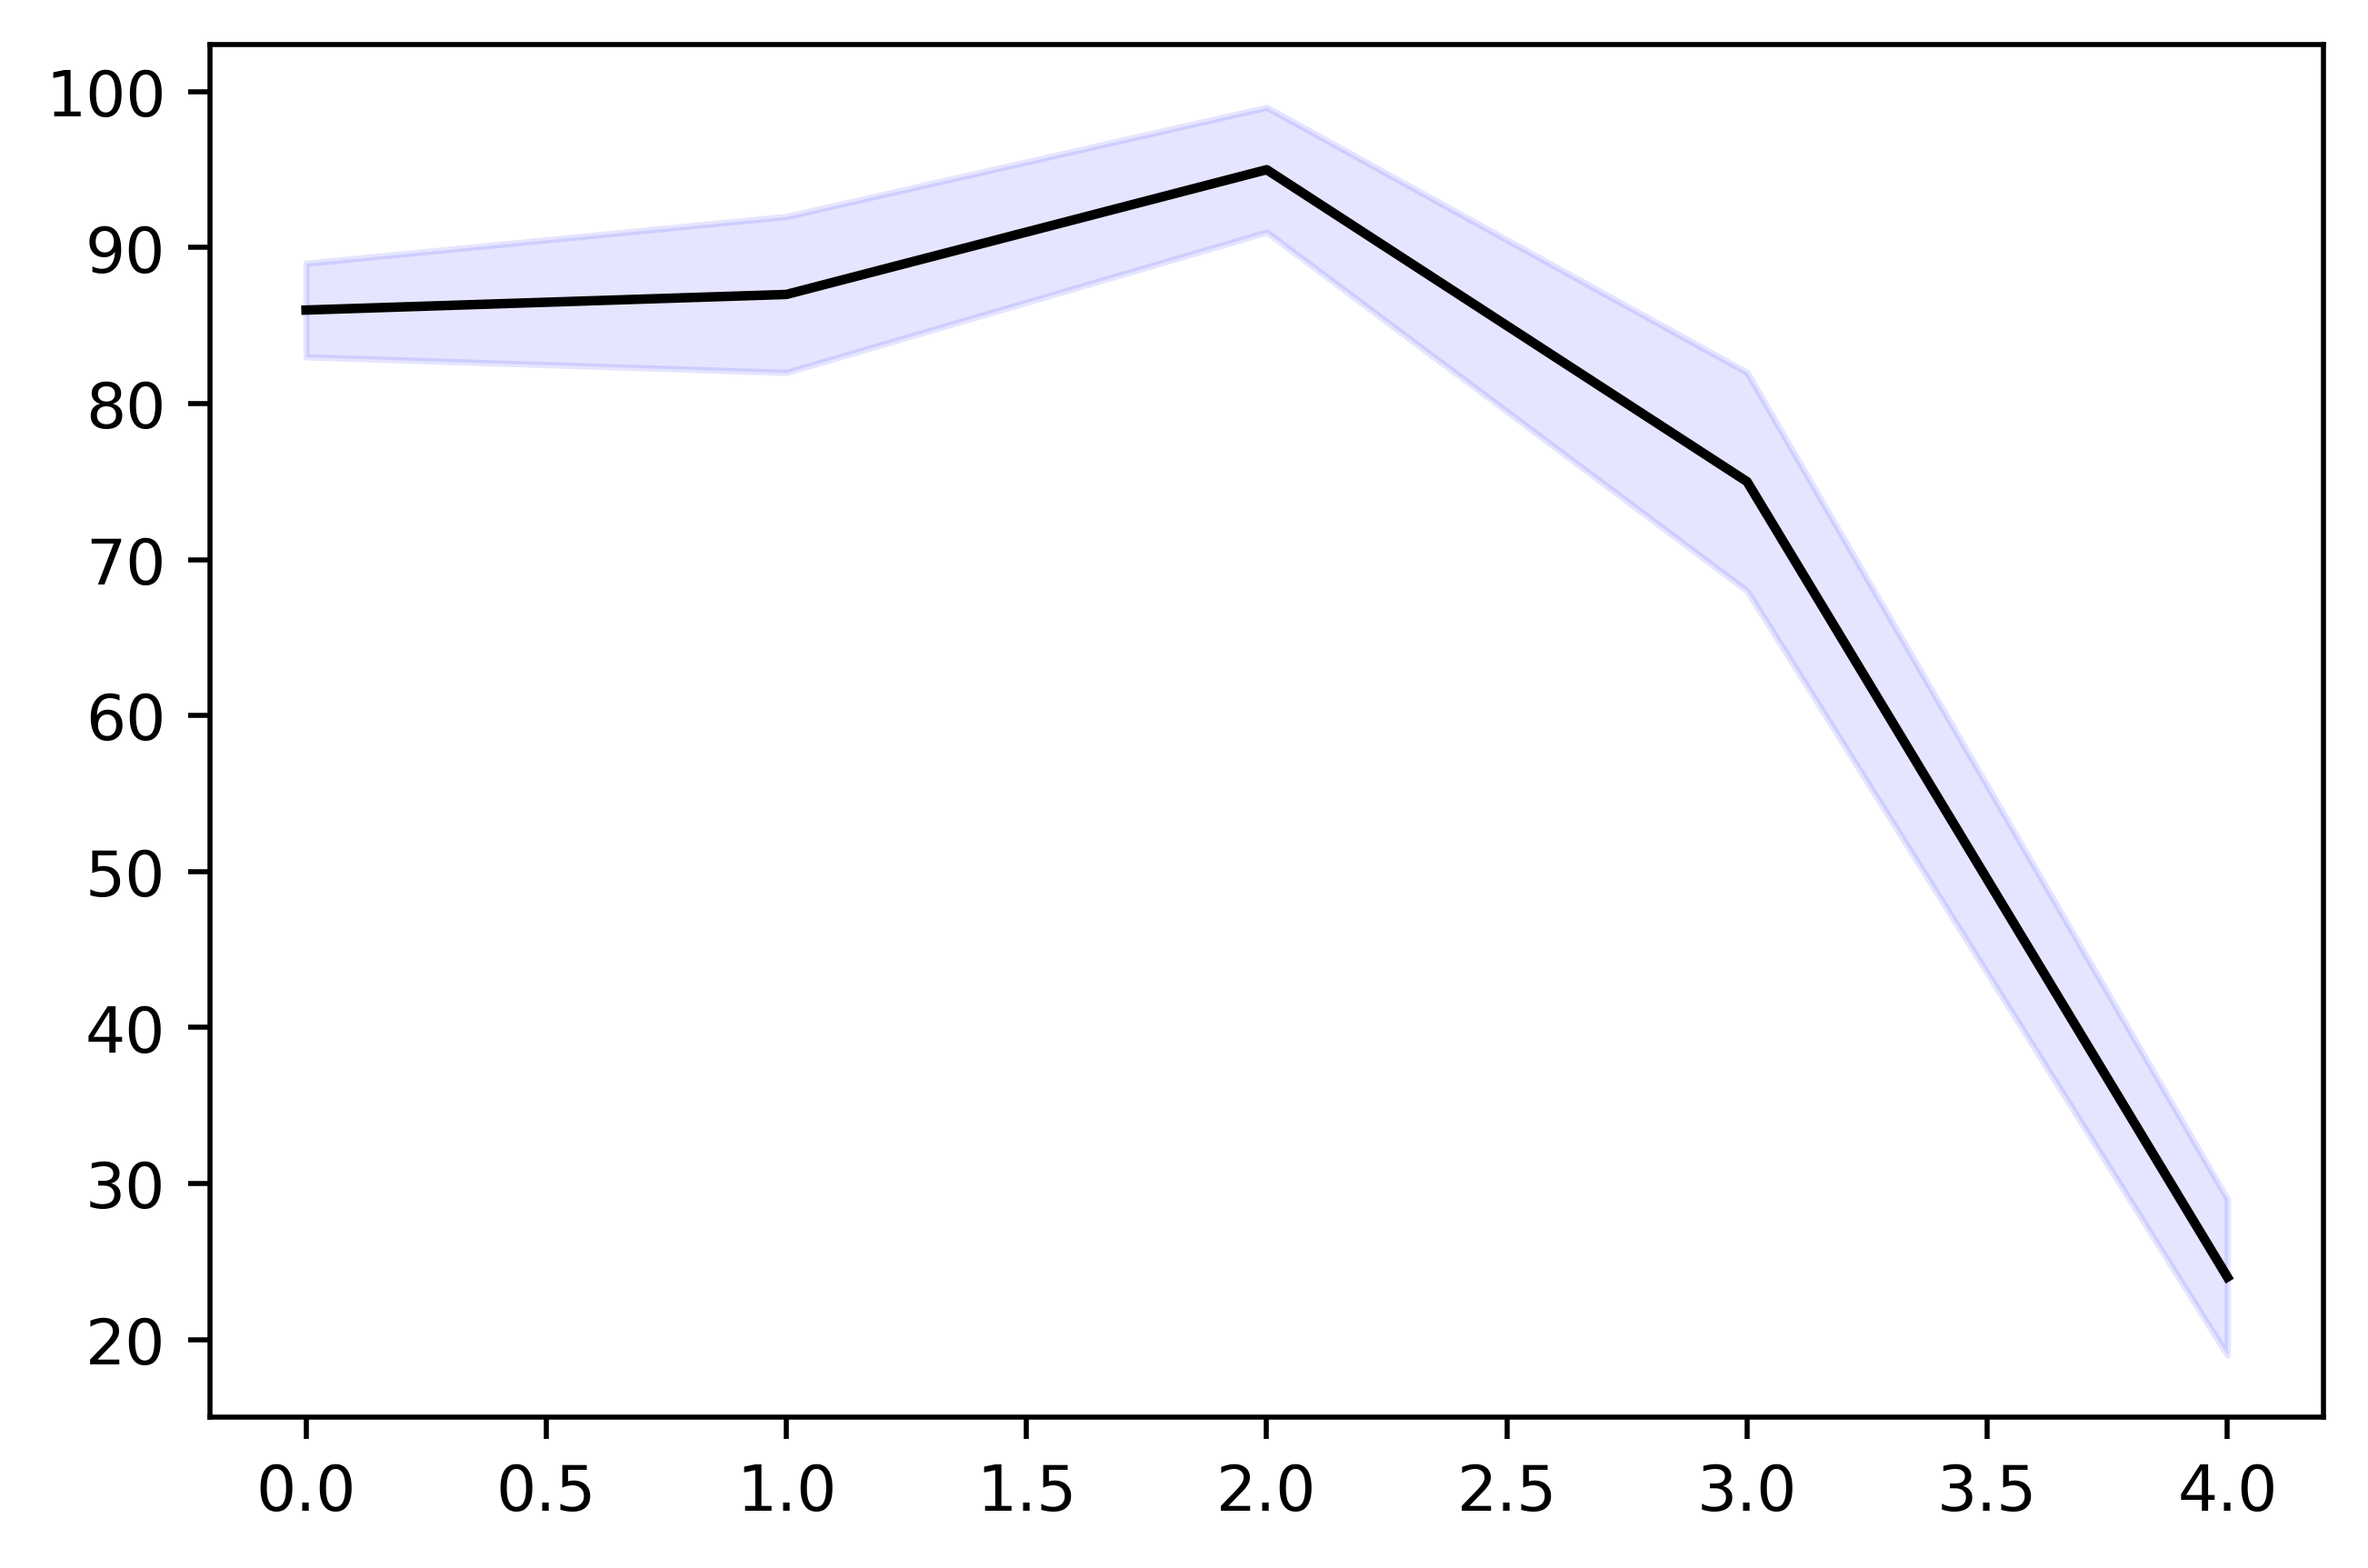

In [3]:
mean = np.array([86,87,95,75,24])
std = np.array([3,5,4,7,5])

fig, ax = plt.subplots()

ax.fill_between(range(5), 
    mean - std,
    mean + std,
    color = 'blue',
    alpha = 0.1
)
ax.plot(range(5), mean, color = 'black')
plt.grid(False)